In [1]:
pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

RETRIEVE THE DATASET FROM UCIREPO

Link keaggle : https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?select=diabetes_binary_health_indicators_BRFSS2015.csv

In [3]:
dataset = fetch_ucirepo(id = 891)
x = dataset.data.features
y = dataset.data.targets
df = pd.concat([x,y], axis=1)
print(dataset.metadata)
print(dataset.variables)

{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

In [4]:
df.shape

(253680, 22)

In [5]:
df.groupby(['Diabetes_binary']).size()

,0
Diabetes_binary,
0,218334
1,35346


FEATURE SELECTION BASED ON CHI2 VALUE

<Axes: >

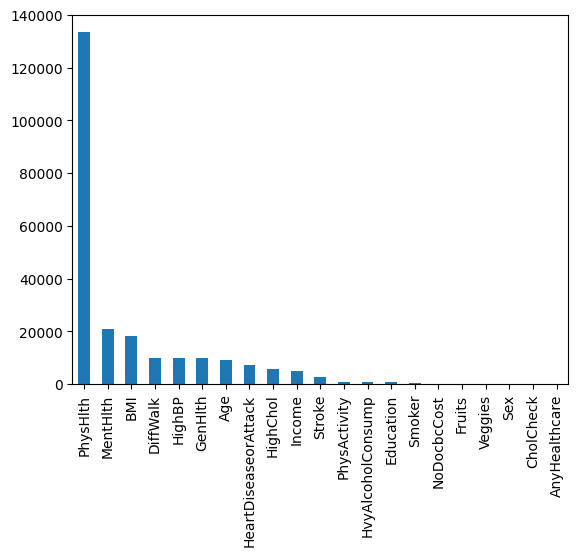

In [6]:
selected_features = SelectKBest(chi2, k=10).fit(x, y)

chi_values = pd.Series(selected_features.scores_, index = x.columns)
chi_values.sort_values(ascending = False, inplace = True)
chi_values.plot.bar()

In [7]:
print(chi_values.nlargest(21, keep='first'))

PhysHlth                133424.406534
MentHlth                 21029.632228
BMI                      18355.166400
DiffWalk                 10059.506391
HighBP                   10029.013935
GenHlth                   9938.507776
Age                       9276.141199
HeartDiseaseorAttack      7221.975378
HighChol                  5859.710582
Income                    4829.816361
Stroke                    2725.225194
PhysActivity               861.887532
HvyAlcoholConsump          779.424807
Education                  756.035496
Smoker                     521.978858
NoDocbcCost                229.542412
Fruits                     154.291404
Veggies                    153.169215
Sex                        140.248274
CholCheck                   39.716825
AnyHealthcare                3.280938
dtype: float64


In [8]:
best_features = ['Age', 'GenHlth', 'PhysHlth', 'MentHlth', 'HighChol', 'HighBP', 'HeartDiseaseorAttack', 'DiffWalk', 'Stroke', 'BMI']
X = df[best_features]
X[['GenHlth', 'PhysHlth', 'MentHlth']] = X[['GenHlth', 'PhysHlth', 'MentHlth']].astype(float)
X.head()

<ipython-input-8-43ce3ee13f02>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['GenHlth', 'PhysHlth', 'MentHlth']] = X[['GenHlth', 'PhysHlth', 'MentHlth']].astype(float)


,Age,GenHlth,PhysHlth,MentHlth,HighChol,HighBP,HeartDiseaseorAttack,DiffWalk,Stroke,BMI
0,9,5.0,15.0,18.0,1,1,0,1,0,40
1,7,3.0,0.0,0.0,0,0,0,0,0,25
2,9,5.0,30.0,30.0,1,1,0,1,0,28
3,11,2.0,0.0,0.0,0,1,0,0,0,27
4,11,2.0,0.0,3.0,1,1,0,0,0,24


In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Age                   253680 non-null  int64  
 1   GenHlth               253680 non-null  float64
 2   PhysHlth              253680 non-null  float64
 3   MentHlth              253680 non-null  float64
 4   HighChol              253680 non-null  int64  
 5   HighBP                253680 non-null  int64  
 6   HeartDiseaseorAttack  253680 non-null  int64  
 7   DiffWalk              253680 non-null  int64  
 8   Stroke                253680 non-null  int64  
 9   BMI                   253680 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 19.4 MB


In [10]:
print(X.shape, y.shape)

(253680, 10) (253680, 1)


In [11]:
y.value_counts()

,count
Diabetes_binary,
0,218334
1,35346


DEEP NEURAL NETWORK MODEL CONSTRUCTION

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train.shape

(202944, 10)

In [14]:
from imblearn.under_sampling import RandomUnderSampler
US = RandomUnderSampler(random_state=42)
X_balance, y_balance = US.fit_resample(X_train, y_train)

In [15]:
y_balance.shape , X_balance.shape

((56698, 1), (56698, 10))

In [16]:
#model 1
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'), #
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'), #
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='relu'), #
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compiling model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
#model 2
import tensorflow as tf

model_2 = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'), #
    tf.keras.layers.Dense(32, activation='relu'), #
    tf.keras.layers.Dense(16, activation='relu'), #
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compiling model
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
#model 3
import tensorflow as tf

model_3 = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'), #
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'), #
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='relu'), #
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compiling model
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [24]:
#model 4
import tensorflow as tf

model_4 = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'), #
    tf.keras.layers.Dense(64, activation='relu'), #
    tf.keras.layers.Dense(16, activation='relu'), #
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compiling model
model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,157 (51.40 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,772 (34.27 KB)

In [44]:
model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,645 (174.40 KB)

 Trainable params: 14,881 (58.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,764 (116.27 KB)

In [17]:
history = model.fit(X_balance, y_balance, epochs=20, batch_size = 32, validation_data=(X_test, y_test))

Epoch 1/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5206 - loss: 0.9440 - val_accuracy: 0.6592 - val_loss: 0.6942
Epoch 2/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5726 - loss: 0.6793 - val_accuracy: 0.7223 - val_loss: 0.6591
Epoch 3/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6200 - loss: 0.6575 - val_accuracy: 0.7122 - val_loss: 0.6038
Epoch 4/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6476 - loss: 0.6347 - val_accuracy: 0.6766 - val_loss: 0.5929
Epoch 5/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6731 - loss: 0.6103 - val_accuracy: 0.7167 - val_loss: 0.5327
Epoch 6/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.6802 - loss: 0.5962 - val_accuracy: 0.7055 - val_loss: 0.5237
Epoch 7/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6975 - loss: 0.5818 - val_accuracy: 0.7258 - val_loss: 0.4910
Epoch 8/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7019 - loss: 0.57

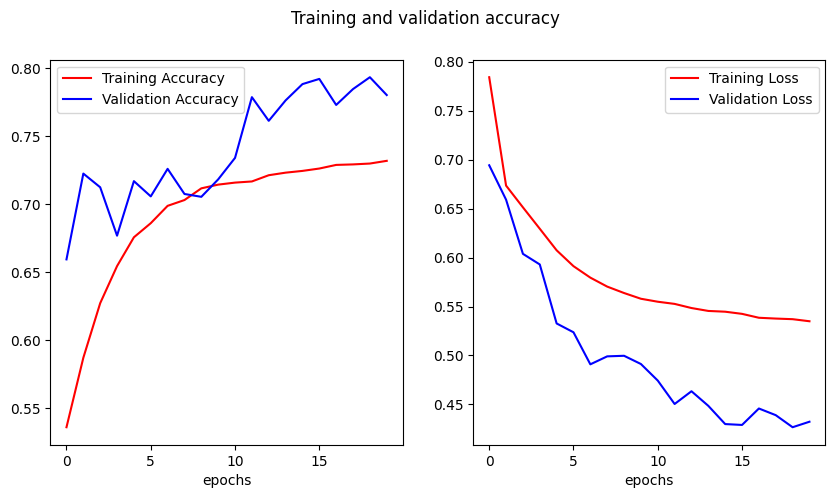

In [18]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#plt.plot(epochs, acc, 'r', label='Training accuracy')
#plt.title('Training accuracy')
#plt.legend(loc=0)
#plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [19]:
y_pred_proba = model.predict(X_test).ravel()

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [20]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

brier = brier_score_loss(y_test, y_pred_proba)
print(f"Brier Score: {brier:.4f}")

Brier Score: 0.1414


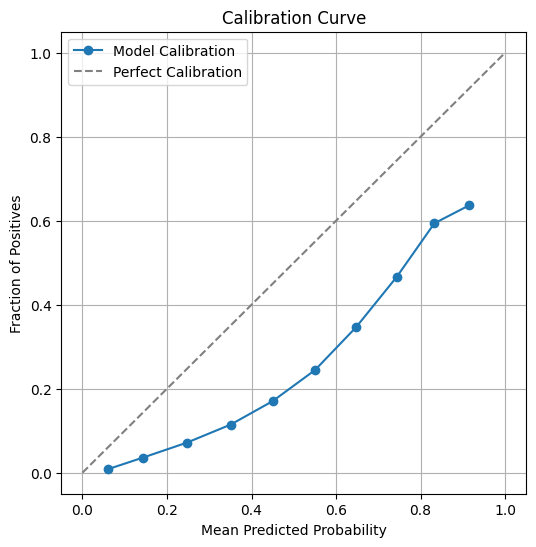

In [21]:
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10, strategy='uniform')

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
history_2 = model_2.fit(X_balance, y_balance, epochs=20, batch_size = 32, validation_data=(X_test, y_test))

Epoch 1/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6007 - loss: 0.6711 - val_accuracy: 0.6174 - val_loss: 0.6768
Epoch 2/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7085 - loss: 0.5751 - val_accuracy: 0.6932 - val_loss: 0.5763
Epoch 3/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7207 - loss: 0.5508 - val_accuracy: 0.7503 - val_loss: 0.4863
Epoch 4/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7255 - loss: 0.5424 - val_accuracy: 0.6466 - val_loss: 0.6344
Epoch 5/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7310 - loss: 0.5334 - val_accuracy: 0.6881 - val_loss: 0.5785
Epoch 6/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7374 - loss: 0.5264 - val_accuracy: 0.7582 - val_loss: 0.4752
Epoch 7/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7353 - loss: 0.5277 - val_accuracy: 0.7014 - val_loss: 0.5513
Epoch 8/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7373 - loss: 0.5251

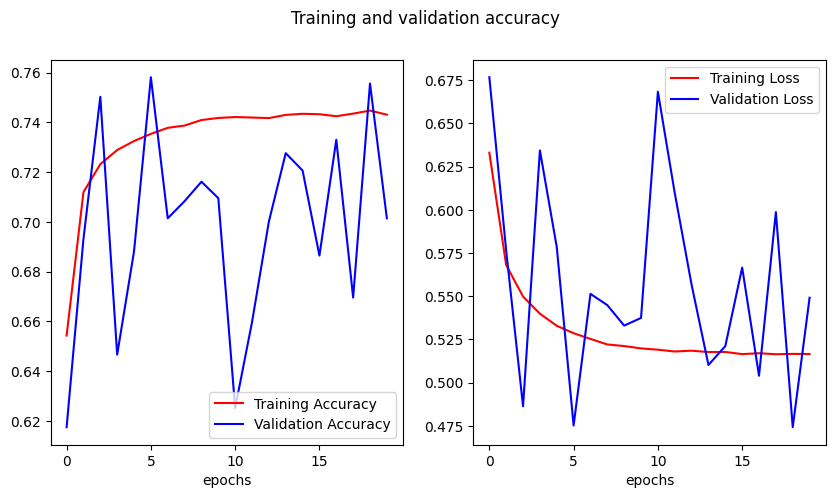

In [26]:
import matplotlib.pyplot as plt
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

#plt.plot(epochs, acc, 'r', label='Training accuracy')
#plt.title('Training accuracy')
#plt.legend(loc=0)
#plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [46]:
y_pred_proba_2 = model_2.predict(X_test).ravel()

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [47]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

brier = brier_score_loss(y_test, y_pred_proba_2)
print(f"Brier Score: {brier:.4f}")

Brier Score: 0.1879


In [29]:
history_3 = model_3.fit(X_balance, y_balance, epochs=20, batch_size = 32, validation_data=(X_test, y_test))

Epoch 1/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5345 - loss: 0.7207 - val_accuracy: 0.6521 - val_loss: 0.6992
Epoch 2/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.6303 - loss: 0.6459 - val_accuracy: 0.5957 - val_loss: 0.6325
Epoch 3/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6802 - loss: 0.6056 - val_accuracy: 0.6556 - val_loss: 0.5782
Epoch 4/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6963 - loss: 0.5814 - val_accuracy: 0.6678 - val_loss: 0.5480
Epoch 5/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7071 - loss: 0.5706 - val_accuracy: 0.6790 - val_loss: 0.5185
Epoch 6/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7119 - loss: 0.5655 - val_accuracy: 0.6742 - val_loss: 0.5415
Epoch 7/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7151 - loss: 0.5594 - val_accuracy: 0.7136 - val_loss: 0.4962
Epoch 8/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7226 - loss: 0.5

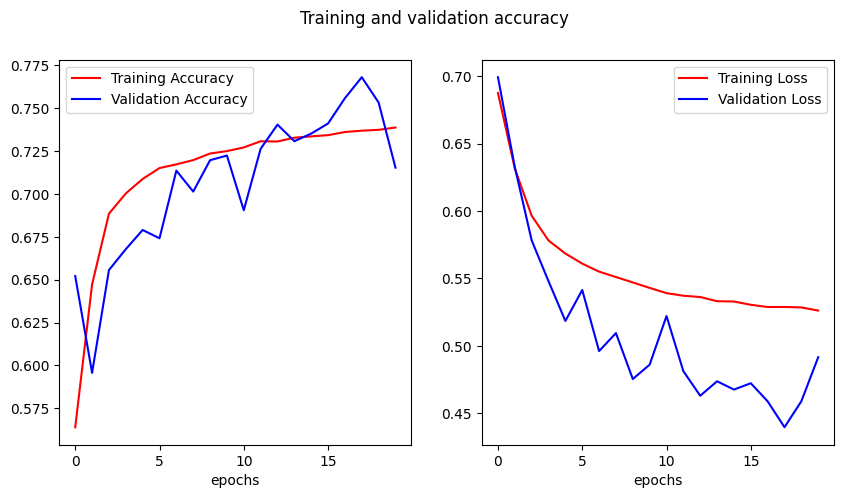

In [30]:
import matplotlib.pyplot as plt
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(len(acc))

#plt.plot(epochs, acc, 'r', label='Training accuracy')
#plt.title('Training accuracy')
#plt.legend(loc=0)
#plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [48]:
y_pred_proba_3 = model_3.predict(X_test).ravel()

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [49]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

brier = brier_score_loss(y_test, y_pred_proba_3)
print(f"Brier Score: {brier:.4f}")

Brier Score: 0.1682


In [33]:
history_4 = model_4.fit(X_balance, y_balance, epochs=20, batch_size = 32, validation_data=(X_test, y_test))

Epoch 1/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6281 - loss: 0.6413 - val_accuracy: 0.6671 - val_loss: 0.6041
Epoch 2/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7155 - loss: 0.5578 - val_accuracy: 0.6827 - val_loss: 0.5877
Epoch 3/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7281 - loss: 0.5426 - val_accuracy: 0.7280 - val_loss: 0.5070
Epoch 4/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7277 - loss: 0.5347 - val_accuracy: 0.6452 - val_loss: 0.6359
Epoch 5/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7348 - loss: 0.5295 - val_accuracy: 0.7079 - val_loss: 0.5342
Epoch 6/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7369 - loss: 0.5242 - val_accuracy: 0.6830 - val_loss: 0.5777
Epoch 7/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7438 - loss: 0.5162 - val_accuracy: 0.7696 - val_loss: 0.4530
Epoch 8/20
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7433 - loss: 0.517

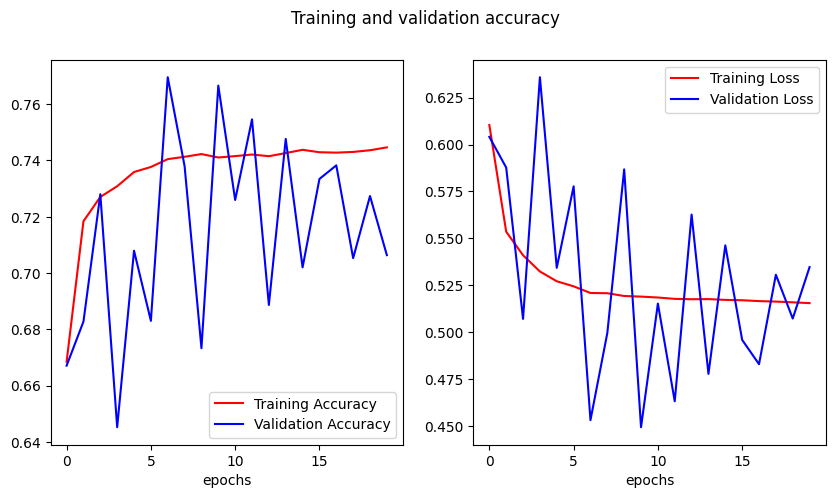

In [34]:
import matplotlib.pyplot as plt
acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs = range(len(acc))

#plt.plot(epochs, acc, 'r', label='Training accuracy')
#plt.title('Training accuracy')
#plt.legend(loc=0)
#plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [50]:
y_pred_proba_4 = model_4.predict(X_test).ravel()

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [51]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

brier = brier_score_loss(y_test, y_pred_proba_4)
print(f"Brier Score: {brier:.4f}")

Brier Score: 0.1831


In [37]:
y_probs_1 = model.predict(X_test).ravel()
roc_auc = roc_auc_score(y_test, y_probs_1)
print(f"ROC AUC Score model 1: {roc_auc:.4f}")

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
ROC AUC Score model 1: 0.8198


In [38]:
y_probs_2 = model_2.predict(X_test).ravel()
roc_auc = roc_auc_score(y_test, y_probs_2)
print(f"ROC AUC Score model 2: {roc_auc:.4f}")

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
ROC AUC Score model 2: 0.8249


In [39]:
y_probs_3 = model_3.predict(X_test).ravel()
roc_auc = roc_auc_score(y_test, y_probs_3)
print(f"ROC AUC Score model 3: {roc_auc:.4f}")

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
ROC AUC Score model 3: 0.8236


In [40]:
y_probs_4 = model_4.predict(X_test).ravel()
roc_auc = roc_auc_score(y_test, y_probs_4)
print(f"ROC AUC Score model 4: {roc_auc:.4f}")

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
ROC AUC Score model 4: 0.8233


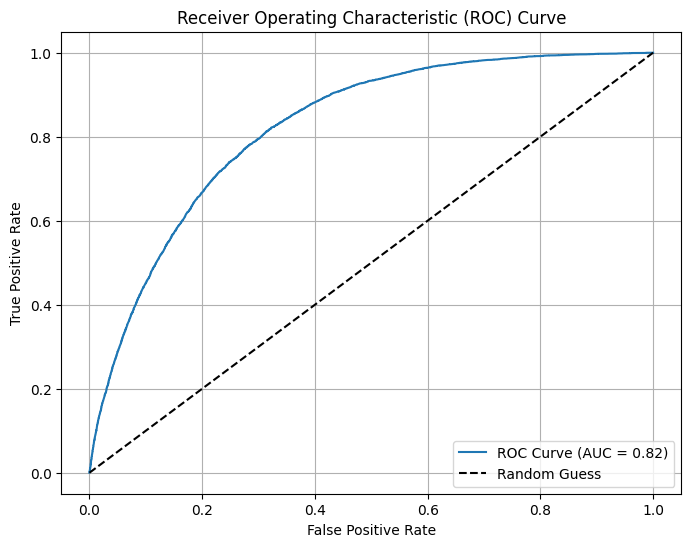

In [41]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs_4)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Convert the model as TFLite format

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model) # model 1 is chosen
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpq470tmlu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10), dtype=tf.float32, name='keras_tensor_16')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135257784016848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135257784018384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135257784017808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135257784019152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135257784018576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135257784019920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135257784019344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135257784020688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135257784020112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135257784021456: TensorSpec(shape=(), dtype=tf.resource, name=None)
